# Imports

In [1]:
import requests
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.util import ngrams
import string
import matplotlib.pyplot as plt
%matplotlib inline


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Loading and pre-processing of text data

In [2]:
# --- Get Turing Award recipients ---

def get_turing_award_recipients():
    """
    Fetches a list of WikiData entities of humans who have received the ACM Turing Award.

    Returns:
        list: A list of WikiData entity IDs of the Turing Award recipients.
    """
    endpoint_url = "https://query.wikidata.org/sparql"

# SPARQL query to fetch entities with ACM Turing Award Q185667 as an award received P166
    sparql_query = """
    SELECT ?entity WHERE {
        ?entity wdt:P166 wd:Q185667.
    }
    """
    
    headers = {"Accept": "application/json"}

    try:
     # Execute the SPARQL query
        response = requests.get(endpoint_url, params={"query": sparql_query, "format": "json"}, headers=headers)

        # Check for successful response
        if response.status_code == 200:
            data = response.json()

             # Extract entity IDs from the response
            entity_ids = [result["entity"]["value"].split("/")[-1] for result in data["results"]["bindings"]]

            return entity_ids
        else:
            print(f"Error: Received status code {response.status_code} from API.")
            return []

    except Exception as e:
        print(f"An error occurred: {e}")
        return []


# Print a list of Turing Award recipients
recipients = get_turing_award_recipients()
print(f"Turing Award Recipients: {recipients}")


Turing Award Recipients: ['Q80', 'Q8556', 'Q9602', 'Q11609', 'Q17457', 'Q45575', 'Q49823', 'Q62843', 'Q62857', 'Q62861', 'Q62866', 'Q62870', 'Q62874', 'Q62877', 'Q62888', 'Q62894', 'Q62898', 'Q92596', 'Q92602', 'Q92604', 'Q92606', 'Q92609', 'Q92612', 'Q92613', 'Q92614', 'Q92618', 'Q92619', 'Q92625', 'Q92626', 'Q92628', 'Q92629', 'Q92632', 'Q92638', 'Q92641', 'Q92643', 'Q92644', 'Q92649', 'Q92670', 'Q92739', 'Q92742', 'Q92743', 'Q92744', 'Q92745', 'Q92746', 'Q92758', 'Q92766', 'Q92781', 'Q92782', 'Q92794', 'Q92819', 'Q92820', 'Q92821', 'Q92822', 'Q92823', 'Q92824', 'Q92828', 'Q92851', 'Q92854', 'Q92894', 'Q92957', 'Q93080', 'Q93154', 'Q93161', 'Q181529', 'Q204815', 'Q320624', 'Q357965', 'Q439245', 'Q462089', 'Q476466', 'Q578036', 'Q918650', 'Q1107006', 'Q3571662', 'Q3572699', 'Q7143512', 'Q16080922']


In [3]:
# --- Get the Wikipedia page content for all recipients ---

def get_wikipedia_title(wikidata_id):
    """
    Fetches the English Wikipedia page title for a given Wikidata ID.

    Args:
        wikidata_id (str): The Wikidata ID of the entity.

    Returns:
        str: The title of the English Wikipedia page or None if not available.
    """
    endpoint_url = "https://www.wikidata.org/w/api.php"

    params = {
        "action": "wbgetentities",
        "format": "json",
        "ids": wikidata_id,
        "props": "sitelinks|claims",
        "languages": "en"
    }

    try:
        response = requests.get(endpoint_url, params=params)

        if response.status_code == 200:
            data = response.json()
            entities = data.get("entities", {})
            entity = entities.get(wikidata_id, {})
            sitelinks = entity.get("sitelinks", {})
            enwiki = sitelinks.get("enwiki", {})

            return enwiki.get("title", None), entity.get("claims", {})
        else:
            print(f"Error: Received status code {response.status_code} from API.")
            return None, {}

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, {}

def get_wikipedia_content(wikidata_id):
    """
    Fetches the content of the english Wikipedia page for a given Wikidata ID.

    Args:
        wikidata_id (str): The Wikidata ID of the entity.

    Returns:
        str: The content of the Wikipedia page or None if the page does not exist.
    """
    title, _ = get_wikipedia_title(wikidata_id)

    if not title:
        print(f"No Wikipedia page found for Wikidata ID: {wikidata_id}")
        return None

    endpoint_url = "https://en.wikipedia.org/w/api.php"

    params = {
        "action": "query",
        "format": "json",
        "prop": "extracts",
        "explaintext": True,
        "redirects": 1,
        "titles": title
    }

    try:
    # Execute the API request
        response = requests.get(endpoint_url, params=params)

        if response.status_code == 200:
            data = response.json()
            pages = data.get("query", {}).get("pages", {})

            for page_id, page_content in pages.items():
                if page_id != "-1":  # Page exists
                    return page_content.get("extract", None)

            return None  # Page does not exist
        else:
            print(f"Error: Received status code {response.status_code} from API.")
            return None

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


# Prints wikipedia page content for prize recipients, showing 3 for proof of functionality
recipients = get_turing_award_recipients()
if recipients:
    for recipient in recipients[:3]:
        content = get_wikipedia_content(recipient)
        print(f"Content for {recipient}:")
        print(content)


Content for Q80:
Sir Timothy John Berners-Lee (born 8 June 1955), also known as TimBL, is an English computer scientist best known as the inventor of the World Wide Web, the HTML markup language, the URL system, and HTTP. He is a professorial research fellow at the University of Oxford and a professor emeritus at the Massachusetts Institute of Technology (MIT).
Berners-Lee proposed an information management system on 12 March 1989 and implemented the first successful communication between a Hypertext Transfer Protocol (HTTP) client and server via the Internet in mid-November.
He devised and implemented the first Web browser and Web server and helped foster the Web's subsequent explosive development. He is the founder and emeritus director of the World Wide Web Consortium (W3C), which oversees the continued development of the Web. He co-founded (with Rosemary Leith) the World Wide Web Foundation. In April 2009, he was elected as Foreign Associate of the National Academy of Sciences.
Ber

In [4]:
# --- Create award_winners dictionary ---

def create_award_winners_dict(recipients):
    """
    Creates a dictionary of award winners with detailed information.

    Args:
        recipients (list): List of Wikidata IDs for the award winners.

    Returns:
        list: A list of dictionaries containing detailed information about each recipient.
    """
    award_winners = []

    for recipient in recipients:
        title, claims = get_wikipedia_title(recipient)
        intro = get_wikipedia_content(recipient)

        # Extract properties from claims
        def extract_property(claims, property_id):
            return [claim["mainsnak"]["datavalue"]["value"] for claim in claims.get(property_id, []) if "datavalue" in claim["mainsnak"]]

        name = title if title else recipient
        gender = extract_property(claims, "P21")
        birth_date = extract_property(claims, "P569")
        birth_place = extract_property(claims, "P19")
        employer = extract_property(claims, "P108")
        educated_at = extract_property(claims, "P69")

        award_winners.append({
            "name": name,
            "intro": intro,
            "gender": gender[0] if gender else None,
            "birth_date": birth_date[0] if birth_date else None,
            "birth_place": birth_place[0] if birth_place else None,
            "employer": employer if employer else None,
            "educated_at": educated_at if educated_at else None
        })

    return award_winners

# Print dict for winners, only showing 3 winners for proof of functionality
recipients = get_turing_award_recipients()
if recipients:
    award_winners = create_award_winners_dict(recipients[:3])
    for winner in award_winners:
        print(winner) 

{'name': 'Tim Berners-Lee', 'intro': 'Sir Timothy John Berners-Lee (born 8 June 1955), also known as TimBL, is an English computer scientist best known as the inventor of the World Wide Web, the HTML markup language, the URL system, and HTTP. He is a professorial research fellow at the University of Oxford and a professor emeritus at the Massachusetts Institute of Technology (MIT).\nBerners-Lee proposed an information management system on 12 March 1989 and implemented the first successful communication between a Hypertext Transfer Protocol (HTTP) client and server via the Internet in mid-November.\nHe devised and implemented the first Web browser and Web server and helped foster the Web\'s subsequent explosive development. He is the founder and emeritus director of the World Wide Web Consortium (W3C), which oversees the continued development of the Web. He co-founded (with Rosemary Leith) the World Wide Web Foundation. In April 2009, he was elected as Foreign Associate of the National 

In [5]:
# --- Print names in alphabetical order ---

def print_award_winners_alphabetically(award_winners):
    """
    Prints the names of award winners in alphabetical order.

    Args:
        award_winners (list): List of dictionaries containing award winners' information.
    """
    sorted_names = sorted([winner["name"] for winner in award_winners if "name" in winner])
    print("\n".join(sorted_names))

# Prints names of award winners sorted by alphabetical order
recipients = get_turing_award_recipients()
if recipients:
    award_winners = create_award_winners_dict(recipients[:])  
    print_award_winners_alphabetically(award_winners)

Adi Shamir
Alan Kay
Alan Perlis
Alfred Aho
Allen Newell
Amir Pnueli
Andrew Yao
Avi Wigderson
Barbara Liskov
Butler Lampson
Charles Bachman
Charles P. Thacker
Dana Scott
David Patterson (computer scientist)
Dennis Ritchie
Donald Knuth
Douglas Engelbart
E. Allen Emerson
Edgar F. Codd
Edmund M. Clarke
Edsger W. Dijkstra
Edward Feigenbaum
Edwin Catmull
Fernando J. Corbató
Frances Allen
Fred Brooks
Geoffrey Hinton
Herbert A. Simon
Ivan Sutherland
Jack Dongarra
James H. Wilkinson
Jeffrey Ullman
Jim Gray (computer scientist)
John Backus
John Cocke (computer scientist)
John Hopcroft
John L. Hennessy
John McCarthy (computer scientist)
Joseph Sifakis
Judea Pearl
Juris Hartmanis
Ken Thompson
Kenneth E. Iverson
Kristen Nygaard
Leonard Adleman
Leslie Lamport
Leslie Valiant
Manuel Blum
Martin Hellman
Marvin Minsky
Maurice Wilkes
Michael O. Rabin
Michael Stonebraker
Niklaus Wirth
Ole-Johan Dahl
Pat Hanrahan
Peter Naur
Raj Reddy
Richard E. Stearns
Richard Hamming
Richard M. Karp
Robert Kahn (computer 

In [ ]:
# --- Create award_winners_intro df ---

def generate_award_winners_intro(award_winners):
    """
    Generates a pandas DataFrame with statistics about the intro text for each award winner.

    Args:
        award_winners (list): List of dictionaries containing award winners' information.

    Returns:
        pd.DataFrame: DataFrame with statistics about the intro text.
    """
    rows = []
    stop_words = set(stopwords.words('english'))
    translator = str.maketrans('', '', string.punctuation)

    for winner in award_winners:
        intro = winner.get("intro", "")
        if intro:
            name = winner["name"]

            # Word, sentence, and paragraph counts
            words = word_tokenize(intro)
            sentences = sent_tokenize(intro)
            paragraphs = intro.split("\n\n")

            word_count = len(words)
            sentence_count = len(sentences)
            paragraph_count = len(paragraphs)

            # Most common words before preprocessing
            word_freq = Counter(words)
            common_words = [word for word, _ in word_freq.most_common(10)]

             # Preprocess to exclude stopwords and punctuation
            filtered_words = [word.lower().translate(translator) for word in words if word.lower() not in stop_words]
            filtered_freq = Counter(filtered_words)
            common_filtered_words = [word for word, _ in filtered_freq.most_common(10)]

            rows.append({
                "winner_name": name,
                "count_words": word_count,
                "count_sentences": sentence_count,
                "count_paragraphs": paragraph_count,
                "common_words": common_words,
                "common_words_after_preprocessing": common_filtered_words
            })

    return pd.DataFrame(rows)

# Print the first 10 rows of the dataframe award_winners_intro
recipients = get_turing_award_recipients()
if recipients:
    award_winners = create_award_winners_dict(recipients) 
    award_winners_intro = generate_award_winners_intro(award_winners)
    print(award_winners_intro.head(10))

                        winner_name  count_words  count_sentences  \
0                   Tim Berners-Lee         2964              109   
1                Edsger W. Dijkstra         4187              178   
2                     Frances Allen         1347               66   
3                  Shafi Goldwasser          893               39   
4                      Donald Knuth         3583              142   
5                    Dennis Ritchie         1902               64   
6                        Dana Scott         1523               76   
7  Robert Kahn (computer scientist)         1774               58   
8                    Maurice Wilkes         1848               78   
9                       Alan Perlis          721               59   

   count_paragraphs                                       common_words  \
0                17   [the, ,, ., of, and, to, a, in, Berners-Lee, he]   
1                30     [,, the, ., of, a, in, and, to, his, Dijkstra]   
2                1

## Applying NLP operations on the corpus

### Stemming

In [ ]:
# --- Stem all words with the PorterStemmer ---

# Remove stopwords and punctuation from all intros
intro_words = []
for winner_info in award_winners:  # Iterate through list of dictionaries directly
    intro = winner_info.get("intro")
    if intro:
        intro_no_punc = intro.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(intro_no_punc.lower())
        stop_words = set(stopwords.words('english'))
        words_no_stopwords = [w for w in tokens if w not in stop_words]
        intro_words.extend(words_no_stopwords)

# Calculate and print the number of unique words
unique_words = set(intro_words)
print(f"Number of unique words before stemming: {len(unique_words)}")

# Apply PorterStemmer
stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(word) for word in intro_words]

# Calculate and print the number of unique stemmed words
unique_stemmed_words = set(stemmed_words)
print(f"Number of unique words after stemming: {len(unique_stemmed_words)}")


Number of unique words before stemming: 10504
Number of unique words after stemming: 8044


In [ ]:
# --- Repeat with SnowballStemmer ---

# Remove stopwords and punctuation from all intros
intro_words = []
for winner_info in award_winners:  # Iterate through the list of dictionaries directly
    intro = winner_info.get("intro")
    if intro:
        intro_no_punc = intro.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(intro_no_punc.lower())
        stop_words = set(stopwords.words('english'))
        words_no_stopwords = [w for w in tokens if w not in stop_words]
        intro_words.extend(words_no_stopwords)

# Calculate and print the number of unique words
unique_words = set(intro_words)
print(f"Number of unique words before stemming: {len(unique_words)}")

# Apply SnowballStemmer
stemmer = SnowballStemmer("english")  # Specify english
stemmed_words = [stemmer.stem(word) for word in intro_words]

# Calculate and print the number of unique stemmed words
unique_stemmed_words = set(stemmed_words)
print(f"Number of unique words after stemming (Snowball): {len(unique_stemmed_words)}")

Number of unique words before stemming: 10504
Number of unique words after stemming (Snowball): 8011


### Lemmatization

In [ ]:
# --- Lemmatize all words ---

# Remove stopwords and punctuation from all intros
intro_words = []
for winner_info in award_winners:  # Iterate through the list of dictionaries directly
    intro = winner_info.get("intro")
    if intro:
        intro_no_punc = intro.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(intro_no_punc.lower())
        stop_words = set(stopwords.words('english'))
        words_no_stopwords = [w for w in tokens if w not in stop_words]
        intro_words.extend(words_no_stopwords)

# Calculate and print the number of unique words
unique_words = set(intro_words)
print(f"Number of unique words before stemming: {len(unique_words)}")

# Apply WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemmatized_words = [lemmatizer.lemmatize(word) for word in intro_words]

# Calculate and print the number of unique lemmatized words
unique_lemmatized_words = set(lemmatized_words)
print(f"Number of unique words after lemmatization: {len(unique_lemmatized_words)}")

Number of unique words before stemming: 10504
Number of unique words after lemmatization: 9662


### Finding synonyms and antonyms

In [ ]:
# --- Find synonyms and antonyms ---

def get_synonyms(word):
    """
    Fetches synonyms for a given word using WordNet.

    Args:
        word (str): The word to find synonyms for.

    Returns:
        list: A list of synonyms.
    """
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return list(set(synonyms))

def get_antonyms(word):
    """
    Fetches antonyms for a given word using WordNet.

    Args:
        word (str): The word to find antonyms for.

    Returns:
        list: A list of antonyms.
    """
    antonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            if lemma.antonyms():
                antonyms.append(lemma.antonyms()[0].name())
    return list(set(antonyms))

def add_synonyms_antonyms_to_dataframe(df):
    """
    Adds synonyms and antonyms columns to the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing common words after preprocessing.

    Returns:
        pd.DataFrame: The updated DataFrame with synonyms and antonyms columns.
    """
    df['synonyms'] = df['common_words_after_preprocessing'].apply(lambda words: [get_synonyms(word) for word in words])
    df['antonyms'] = df['common_words_after_preprocessing'].apply(lambda words: [get_antonyms(word) for word in words])
    return df

# Prints the first ten rows of the dataframe
recipients = get_turing_award_recipients()
if recipients:
    award_winners = create_award_winners_dict(recipients[:])  
    award_winners_intro = generate_award_winners_intro(award_winners)
    award_winners_intro = add_synonyms_antonyms_to_dataframe(award_winners_intro)
    print(award_winners_intro.head(10))


                        winner_name  count_words  count_sentences  \
0                   Tim Berners-Lee         2964              109   
1                Edsger W. Dijkstra         4187              178   
2                     Frances Allen         1347               66   
3                  Shafi Goldwasser          893               39   
4                      Donald Knuth         3583              142   
5                    Dennis Ritchie         1902               64   
6                        Dana Scott         1523               76   
7  Robert Kahn (computer scientist)         1774               58   
8                    Maurice Wilkes         1848               78   
9                       Alan Perlis          721               59   

   count_paragraphs                                       common_words  \
0                17   [the, ,, ., of, and, to, a, in, Berners-Lee, he]   
1                30     [,, the, ., of, a, in, and, to, his, Dijkstra]   
2                1

### Bigrams and trigrams

In [95]:
def tokenize_intro_texts(award_winners):
    """
    Tokenizes the intro texts of award winners into individual tokens.

    Args:
        award_winners (list): List of dictionaries containing award winners information.

    Returns:
        list: List of lists, each inner list contains tokens from the intro text.
    """
    tokenized_texts = []
    for winner in award_winners:
        intro = winner.get("intro", "")
        if intro:
            tokens = word_tokenize(intro)
            tokenized_texts.append(tokens)
    return tokenized_texts

# Print for first 10
recipients = get_turing_award_recipients()
if recipients:
    award_winners = create_award_winners_dict(recipients[:]) 
    award_winners_intro = generate_award_winners_intro(award_winners)
    award_winners_intro = add_synonyms_antonyms_to_dataframe(award_winners_intro)
    print(award_winners_intro.head(10))

    tokenized_texts = tokenize_intro_texts(award_winners)
    print(tokenized_texts)

                        winner_name  count_words  count_sentences  \
0                   Tim Berners-Lee         2964              109   
1                Edsger W. Dijkstra         4187              178   
2                     Frances Allen         1347               66   
3                  Shafi Goldwasser          893               39   
4                      Donald Knuth         3583              142   
5                    Dennis Ritchie         1902               64   
6                        Dana Scott         1523               76   
7  Robert Kahn (computer scientist)         1774               58   
8                    Maurice Wilkes         1848               78   
9                       Alan Perlis          721               59   

   count_paragraphs                                       common_words  \
0                17   [the, ,, ., of, and, to, a, in, Berners-Lee, he]   
1                30     [,, the, ., of, a, in, and, to, his, Dijkstra]   
2                1

In [79]:
def get_bigrams_frequency(intro_texts):
    """
    Extracts bigrams and calculates their frequencies from a list of intro texts.

    Args:
        intro_texts (list): List of intro texts.

    Returns:
        dict: Dictionary with key-value pairs of bigrams and their frequencies
    """
    stop_words = set(stopwords.words('english'))
    translator = str.maketrans('', '', string.punctuation)
    bigram_counter = Counter()

    for intro in intro_texts:
        if intro:
            tokens = [word.lower().translate(translator) for word in word_tokenize(intro) if word.lower() not in stop_words]
            bigrams = ngrams(tokens, 2)
            bigram_counter.update(bigrams)

    return dict(bigram_counter)

In [21]:
# Save the dictionary in variable named winners_bigrams
intro_texts = [winner.get("intro", "") for winner in award_winners if winner.get("intro")]
winners_bigrams = get_bigrams_frequency(intro_texts)
print(winners_bigrams)

{('sir', 'timothy'): 1, ('timothy', 'john'): 1, ('john', 'bernerslee'): 1, ('bernerslee', ''): 5, ('', 'born'): 5, ('born', '8'): 1, ('8', 'june'): 2, ('june', '1955'): 2, ('1955', ''): 2, ('', ''): 247, ('', 'also'): 10, ('also', 'known'): 2, ('known', 'timbl'): 1, ('timbl', ''): 2, ('', 'english'): 1, ('english', 'computer'): 1, ('computer', 'scientist'): 10, ('scientist', 'best'): 1, ('best', 'known'): 1, ('known', 'inventor'): 1, ('inventor', 'world'): 3, ('world', 'wide'): 20, ('wide', 'web'): 20, ('web', ''): 18, ('', 'html'): 1, ('html', 'markup'): 1, ('markup', 'language'): 1, ('language', ''): 6, ('', 'url'): 1, ('url', 'system'): 1, ('system', ''): 14, ('', 'http'): 2, ('http', ''): 2, ('', 'professorial'): 1, ('professorial', 'research'): 2, ('research', 'fellow'): 5, ('fellow', 'university'): 1, ('university', 'oxford'): 2, ('oxford', 'professor'): 1, ('professor', 'emeritus'): 3, ('emeritus', 'massachusetts'): 1, ('massachusetts', 'institute'): 5, ('institute', 'technology

In [ ]:
# Print the 15 most frequently occurring bigrams
most_common_bigrams = Counter(winners_bigrams).most_common(15)
print("15 Most Frequently Occurring Bigrams:")
for bigram, frequency in most_common_bigrams:
    print(f"{bigram}: {frequency}")

15 Most Frequently Occurring Bigrams:
('', ''): 247
('', 'knuth'): 60
('computer', 'science'): 47
('', 'dijkstra'): 46
('', 'bernerslee'): 33
('science', ''): 28
('programming', ''): 24
('world', 'wide'): 20
('wide', 'web'): 20
('web', ''): 18
('', 'allen'): 18
('', 'goldwasser'): 15
('computer', 'programming'): 15
('system', ''): 14
('', 'became'): 14


## Visualisation

### Barplots

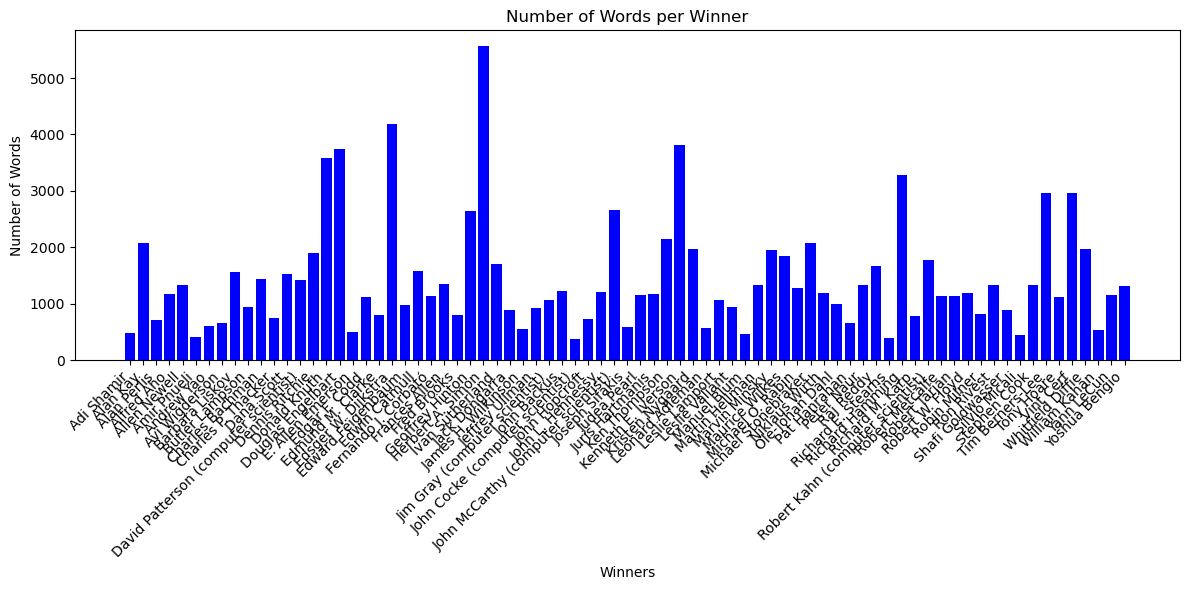

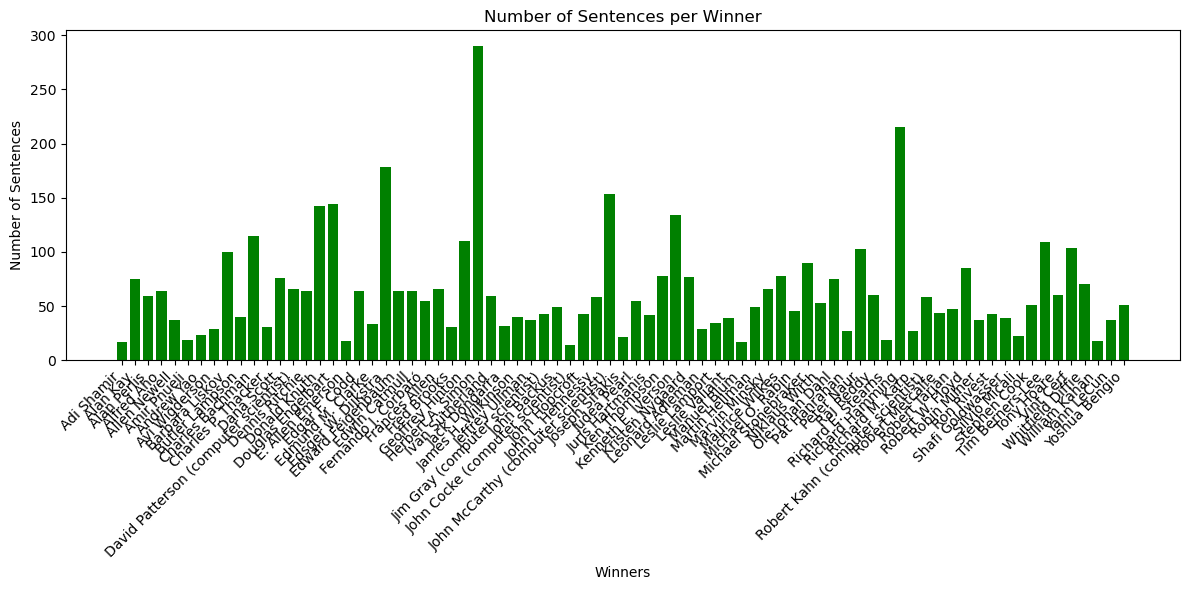

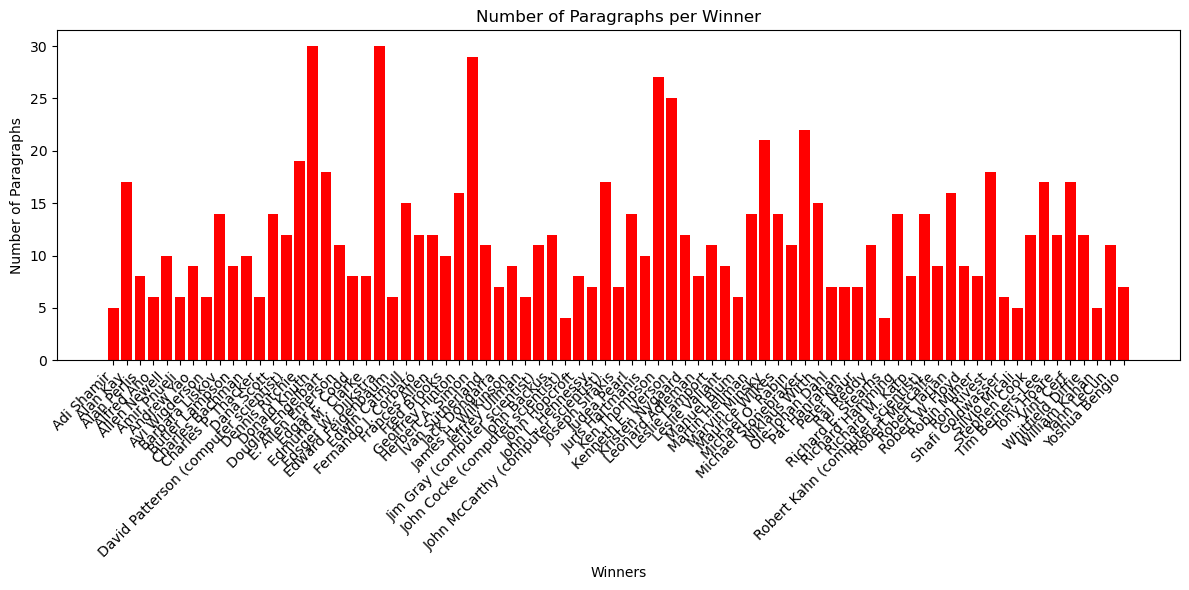

In [97]:
def plot_barplots(award_winners_intro):
    """
    Creates barplots for the number of words, sentences, and paragraphs per winner.

    Args:
        award_winners_intro (DataFrame): DataFrame containing the data.
    """
    if award_winners_intro.empty:
        print("The DataFrame is empty. Cannot plot barplots.")
        return

     # Sort DataFrame to make plots more readable
    award_winners_intro = award_winners_intro.sort_values(by='winner_name')

    # Plot 1: Number of words per winner
    plt.figure(figsize=(12, 6))
    plt.bar(award_winners_intro['winner_name'], award_winners_intro['count_words'], color='blue')
    plt.xlabel('Winners')
    plt.ylabel('Number of Words')
    plt.title('Number of Words per Winner')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Plot 2: Number of sentences per winner
    plt.figure(figsize=(12, 6))
    plt.bar(award_winners_intro['winner_name'], award_winners_intro['count_sentences'], color='green')
    plt.xlabel('Winners')
    plt.ylabel('Number of Sentences')
    plt.title('Number of Sentences per Winner')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Plot 3: Number of paragraphs per winner
    plt.figure(figsize=(12, 6))
    plt.bar(award_winners_intro['winner_name'], award_winners_intro['count_paragraphs'], color='red')
    plt.xlabel('Winners')
    plt.ylabel('Number of Paragraphs')
    plt.title('Number of Paragraphs per Winner')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Call the function to plot barplots
plot_barplots(award_winners_intro)


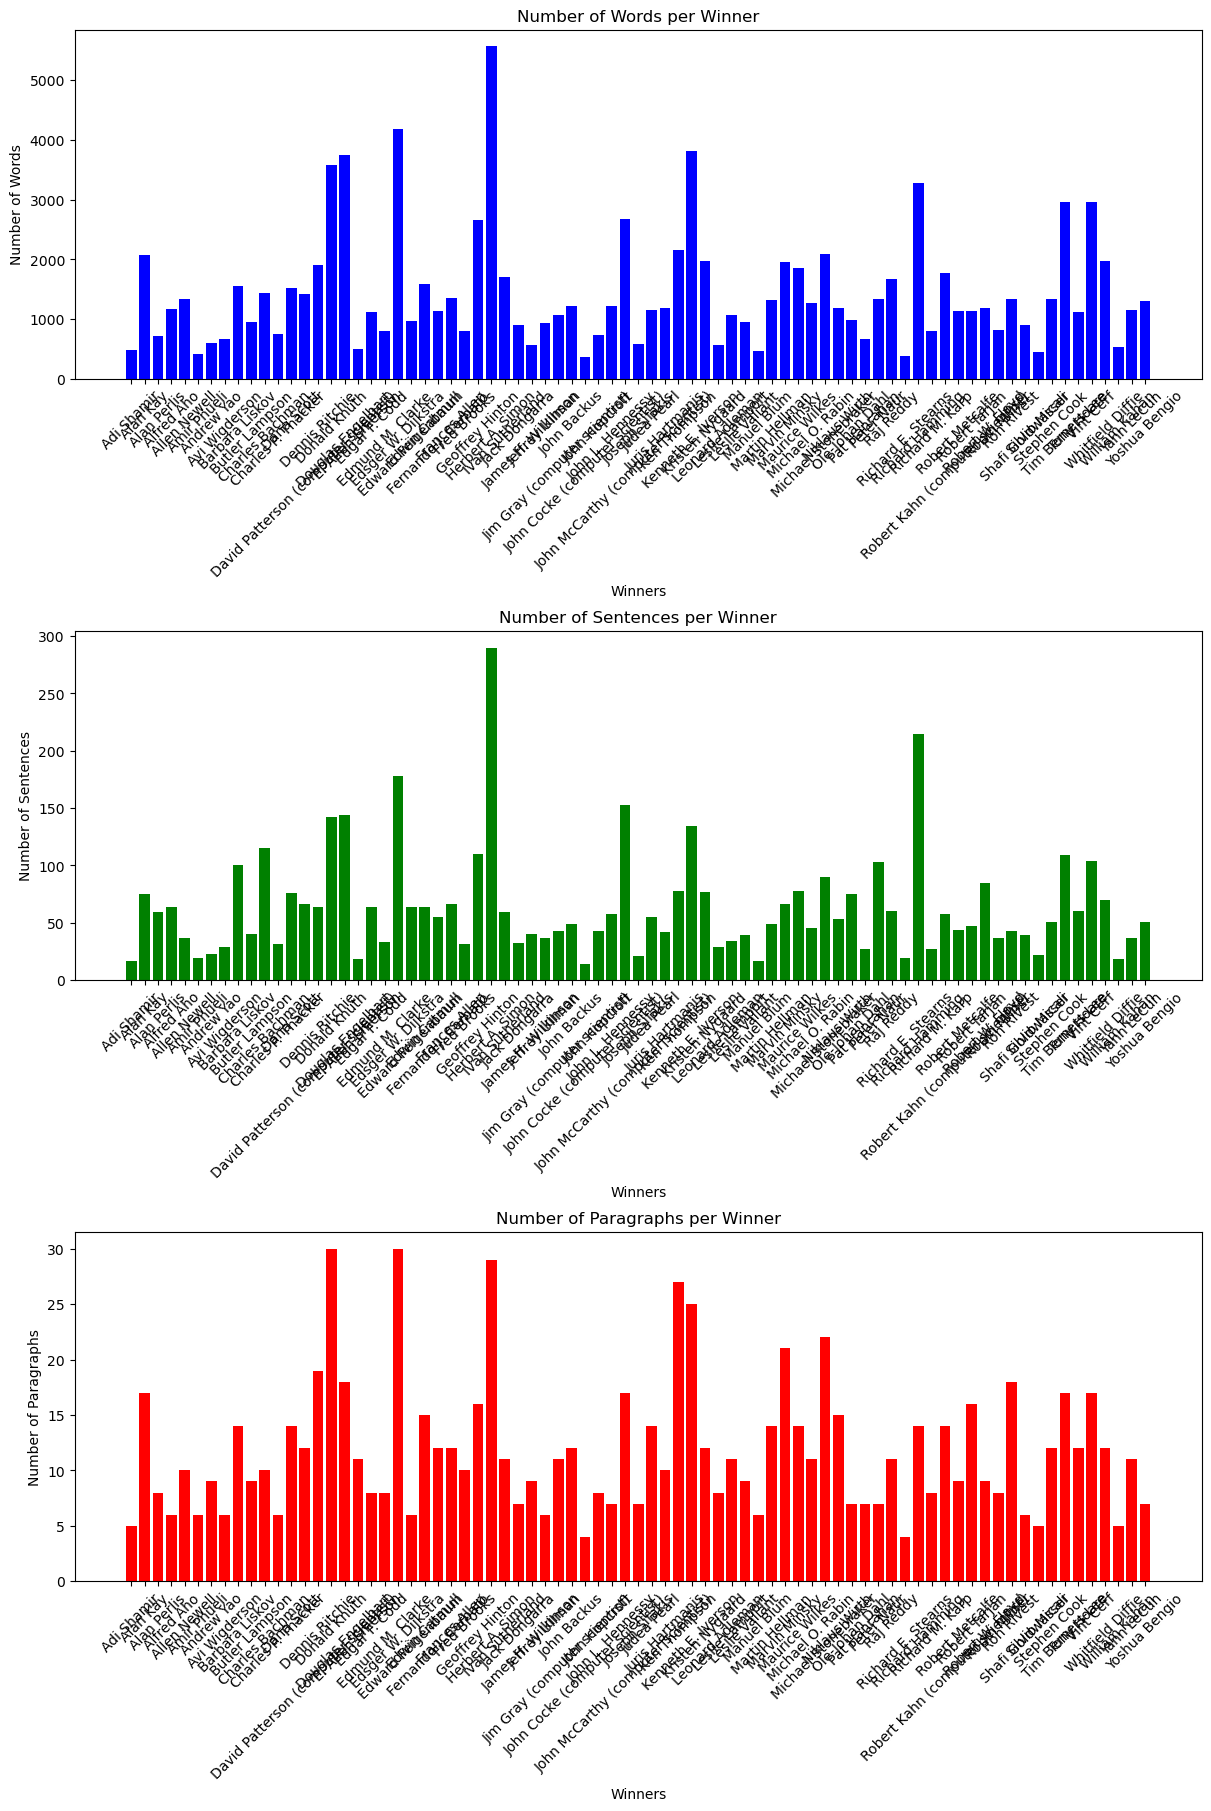

In [100]:
def plot_barplots(award_winners_intro):
    """
    Creates barplots for the number of words, sentences, and paragraphs per winner in a single figure.

    Args:
        award_winners_intro (DataFrame): DataFrame containing the data.
    """
    if award_winners_intro.empty:
        print("The DataFrame is empty. Cannot plot barplots.")
        return

    # Sort DataFrame to make plots more readable
    award_winners_intro = award_winners_intro.sort_values(by='winner_name')

    # Create subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 18), constrained_layout=True)

    # Plot 1: Number of words per winner
    axs[0].bar(award_winners_intro['winner_name'], award_winners_intro['count_words'], color='blue')
    axs[0].set_xlabel('Winners')
    axs[0].set_ylabel('Number of Words')
    axs[0].set_title('Number of Words per Winner')
    axs[0].tick_params(axis='x', rotation=45)

    # Plot 2: Number of sentences per winner
    axs[1].bar(award_winners_intro['winner_name'], award_winners_intro['count_sentences'], color='green')
    axs[1].set_xlabel('Winners')
    axs[1].set_ylabel('Number of Sentences')
    axs[1].set_title('Number of Sentences per Winner')
    axs[1].tick_params(axis='x', rotation=45)

    # Plot 3: Number of paragraphs per winner
    axs[2].bar(award_winners_intro['winner_name'], award_winners_intro['count_paragraphs'], color='red')
    axs[2].set_xlabel('Winners')
    axs[2].set_ylabel('Number of Paragraphs')
    axs[2].set_title('Number of Paragraphs per Winner')
    axs[2].tick_params(axis='x', rotation=45)

    # Display the figure
    plt.show()

# Call the function to plot barplots
plot_barplots(award_winners_intro)

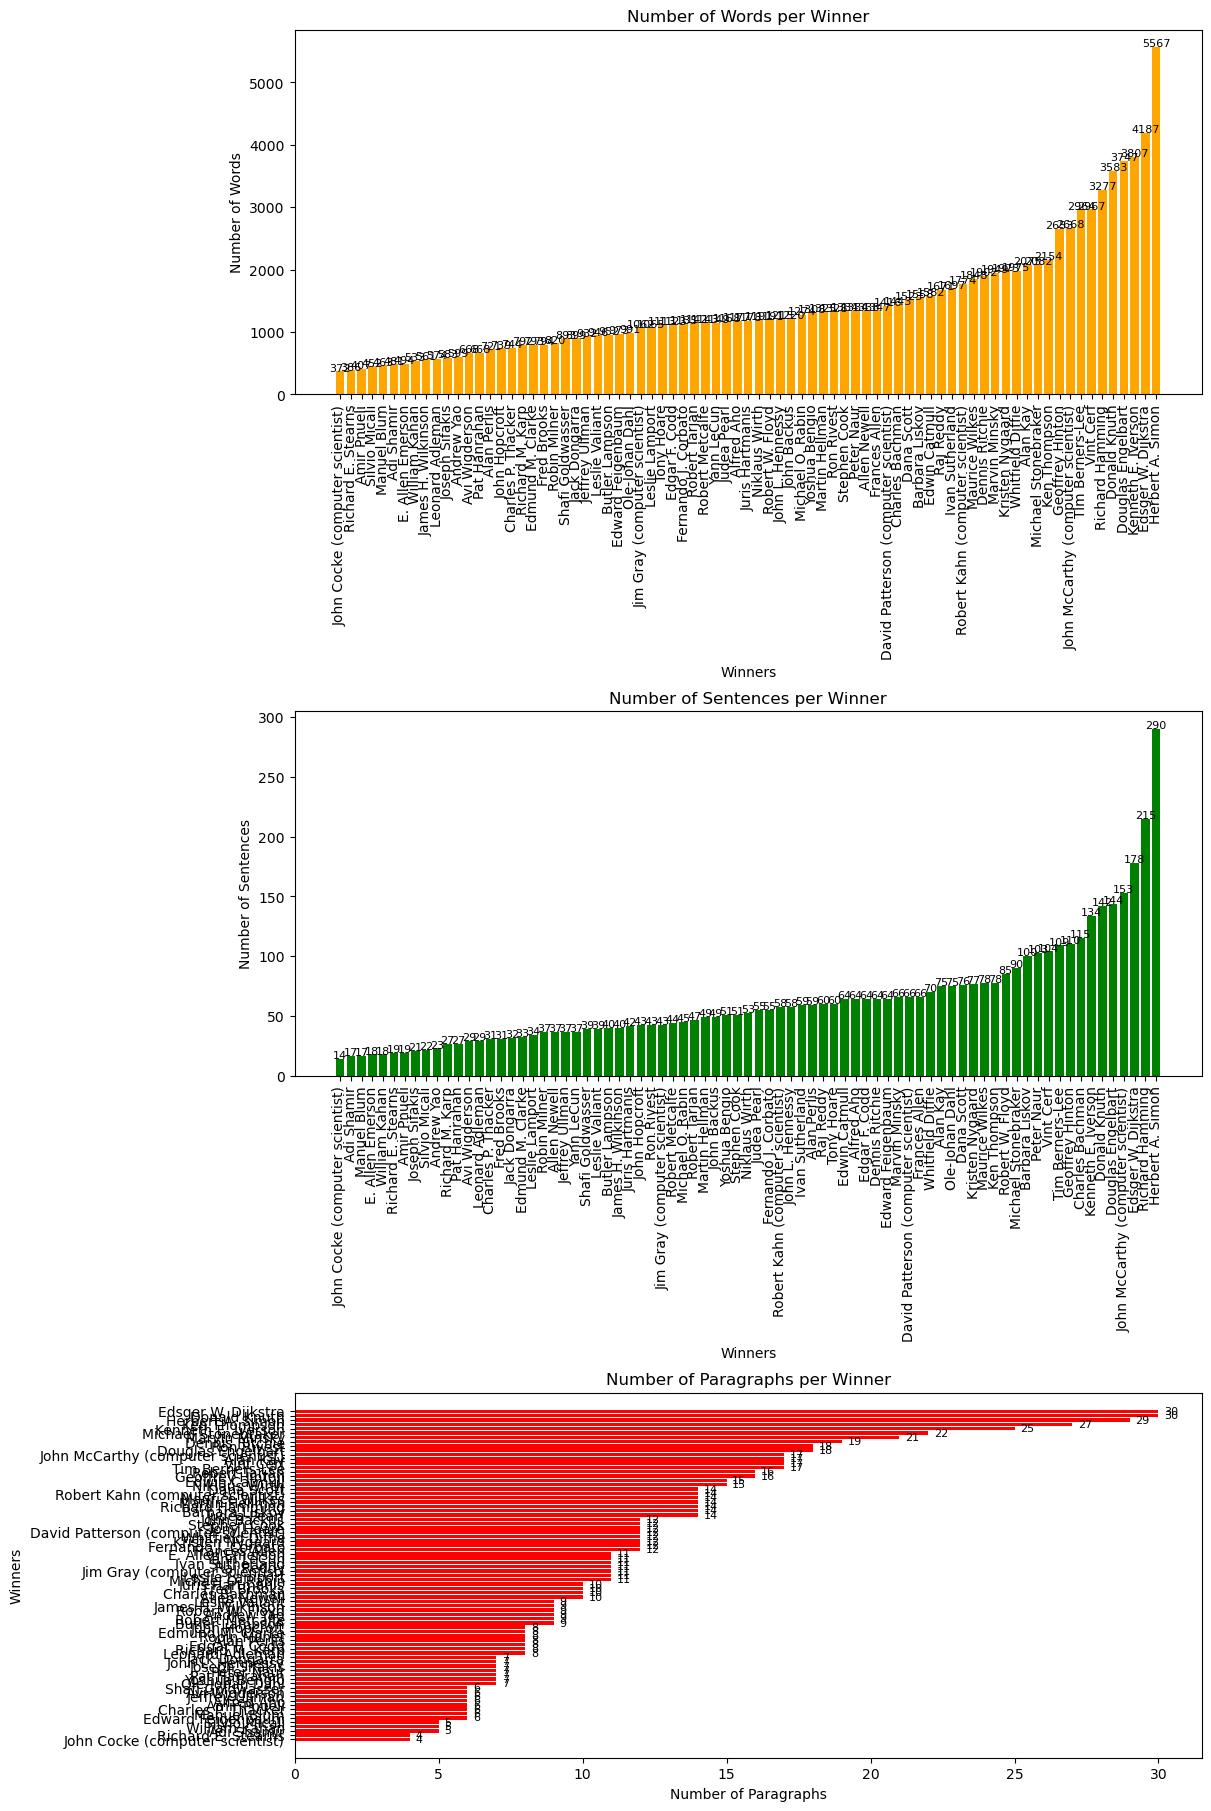

In [105]:
def plot_barplots(award_winners_intro):
    """
    Creates barplots for the number of words, sentences, and paragraphs per winner in a single figure,
    with additional customization as per requirements.

    Args:
        award_winners_intro (DataFrame): DataFrame containing the data.
    """
    if award_winners_intro.empty:
        print("The DataFrame is empty. Cannot plot barplots.")
        return

# Sort the DataFrame in ascending order for each metric
    words_sorted = award_winners_intro.sort_values(by='count_words')
    sentences_sorted = award_winners_intro.sort_values(by='count_sentences')
    paragraphs_sorted = award_winners_intro.sort_values(by='count_paragraphs')

    # Create subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 18), constrained_layout=True)

    # Plot 1: Number of words per winner with customized color and rotated labels
    axs[0].bar(words_sorted['winner_name'], words_sorted['count_words'], color='orange')
    axs[0].set_xlabel('Winners')
    axs[0].set_ylabel('Number of Words')
    axs[0].set_title('Number of Words per Winner')
    axs[0].tick_params(axis='x', rotation=90)
    for i, v in enumerate(words_sorted['count_words']):
        axs[0].text(i, v + 5, str(v), ha='center', fontsize=8)

    # Plot 2: Number of sentences per winner with rotated labels
    axs[1].bar(sentences_sorted['winner_name'], sentences_sorted['count_sentences'], color='green')
    axs[1].set_xlabel('Winners')
    axs[1].set_ylabel('Number of Sentences')
    axs[1].set_title('Number of Sentences per Winner')
    axs[1].tick_params(axis='x', rotation=90)
    for i, v in enumerate(sentences_sorted['count_sentences']):
        axs[1].text(i, v + 0.5, str(v), ha='center', fontsize=8)

    # Plot 3: Horizontal barplot for paragraphs
    axs[2].barh(paragraphs_sorted['winner_name'], paragraphs_sorted['count_paragraphs'], color='red')
    axs[2].set_xlabel('Number of Paragraphs')
    axs[2].set_ylabel('Winners')
    axs[2].set_title('Number of Paragraphs per Winner')
    for i, v in enumerate(paragraphs_sorted['count_paragraphs']):
        axs[2].text(v + 0.2, i, str(v), va='center', fontsize=8)

    # Display the figure
    plt.show()

# Call the function to plot barplots
plot_barplots(award_winners_intro)
